## Pre-processing

In [1]:
import numpy as np
import pandas as pd

UG_courses = ["BOA","BOB","BOC","BOE","BSC"]
Df = pd.read_csv("synthetic_Data_truncated_normal_approach2.csv")
print("size of dataframe:",Df.shape)
Df["COURSE_CODE"] = Df["COURSE_CODE"].fillna('not_taking')
Df = Df[Df.columns].fillna('0')
Df.isnull().sum().sum()

Df = Df.loc[Df['COURSE_CODE'] != 'not_taking']
Df = Df.reset_index()
X = Df[Df.columns.difference(['CODE_DESCR_mast','COURSE_CODE'])]
y = Df[['CODE_DESCR_mast','COURSE_CODE']]
print("X has size:",X.shape, " and y has size:",y.shape)


size of dataframe: (24017, 108)
X has size: (5437, 107)  and y has size: (5437, 2)


In [2]:
## select column that needs to do binary encoding 
subject_course_list = []
for course in UG_courses:
    for i in range(0,16):
        subject_course_list += [course+'subject'+str(i+1)]
profile_title_list = X.columns.difference(subject_course_list)

useless_profile_title_list = ['STU_ID_PROXY','CODE_DESCR_bach','FACULTY_CODE_mast','LANGUAGE_TEST_SCORE','LANGUAGE_TEST_TYPE']+['FACULTY_CODE_mast']
# data cleaning, to sparse, or useless
useful_profile_title_list= list(set(profile_title_list)-set(useless_profile_title_list))
column_title_need_onehotEncode = ['COURSE_CREDITS_REQ_bach','FACULTY_CODE_bach','LOCATION_CODE_bach','top5_bach_bach',
                                  'AGE_BAND','STATE','HOME_LANGUAGE','ATAR_BAND',
                                  'COURSE_CREDITS_REQ_mast','LOCATION_CODE_mast','STUDY_YEAR_mast','N_SUBJECTS_mast']
X.isnull().sum().sum()

print("X has size:",X.shape)


X has size: (5437, 107)


In [3]:

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder

####binary encoder
encoder = LabelBinarizer()
# Y_values = encoder.fit_transform(y["COURSE_CODE"].values)
Y_values = y["COURSE_CODE"]
X_part1 = pd.DataFrame({})
for column in column_title_need_onehotEncode:
    column_values=X[column_title_need_onehotEncode][column].astype(str)
    binarised_x = encoder.fit_transform(column_values.values)
    X_part1 = pd.concat([X_part1,pd.DataFrame(binarised_x)],axis=1)
X_part2 = X[list(set(useful_profile_title_list)-set(column_title_need_onehotEncode))]
X_part2 = X_part2.reset_index(drop=True)
X_values = pd.concat([pd.DataFrame(X_part1),X_part2], axis = 1)

print("X has size:",X_values.shape, " and y has size:",Y_values.shape)


X has size: (5437, 90)  and y has size: (5437,)


# modelling without Synthetic



In [4]:

res_dict = pd.DataFrame(data = {"method":[],
            "with Synthetic Data":[],
            "Train set size":[],
            "Test set size":[],
             "f1_score_weighted":[],
            "accuracy_score":[],
            })


In [5]:
n=5

In [6]:
def accuracy_at_number_n(n,recomm,Ytest):
    res = {}
    total = len(Ytest)

    res = [0]*n
      
    for index, row in recomm.iterrows():
        for each in range(n):
            if Ytest[index] == row.values[each]:
                res[each] +=1   
            
    res = list(map(lambda x:round(x/total,3), res))
    return res

In [7]:
from sklearn import metrics

def add_res(n,domain,res,model,method,SynData,X_train,X_test,Y_test,proportion):
    Y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test) 
#     best_n = np.argsort(probs, axis=1)[:,:-n]
    best_n = np.argsort(-probs, axis=1)[:,:-n]
    #then find the associated SOC code for each prediction
    top_class = cls.classes_[best_n]
    #cast to a new dataframe
    top_class_df = pd.DataFrame(data=top_class)    
    this_res= accuracy_at_number_n(n,top_class_df,Y_test)
    this_row = {"method":method,
            "with Synthetic Data":SynData,
            "Train set size":int(X_train.shape[0]),
            "Test set size":int(X_test.shape[0]),
            "target-source domain proportion":proportion,
             "f1_score_weighted":metrics.f1_score(Y_test, Y_pred, average="weighted"),
            "accuracy_score":metrics.accuracy_score(Y_test, Y_pred),
               "domain":domain}
    for i in range(n):
        this_row["accuracy at "+str(i+1)] = this_res[i]
        if i<2:
            recom_course = top_class_df[i].value_counts()[:1].index.tolist()     
            this_row["recommendation "+ "Top "+str(i+1)+"most frequent"] = recom_course
            recom_course = top_class_df[i].value_counts()[1:2].index.tolist()     
            this_row["recommendation "+ "Top "+str(i+1)+"second most frequent"] = recom_course
    res = res.append(this_row,ignore_index=True)
    return res


In [8]:
# take BOA out 
import timeit
start = timeit.default_timer()

from sklearn.model_selection import train_test_split
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# BOA
for domain_index in range(5):
    domain = UG_courses[domain_index]

    new_Df = pd.concat([pd.DataFrame(X_values),pd.DataFrame(Y_values)],axis = 1)
    target_Df = new_Df.loc[new_Df['UG_course']==UG_courses[domain_index]]
    source_Df =  new_Df.loc[new_Df['UG_course']!=UG_courses[domain_index]]
    target_Df = target_Df.drop("UG_course", axis=1)
    source_Df = source_Df.drop("UG_course", axis=1)

    Y_column_name = 'COURSE_CODE'
    Y_target_values = target_Df[Y_column_name].values
    X_target_values = target_Df[target_Df.columns.difference([Y_column_name])]
    X_target_train, X_test, Y_target_train, Y_test = train_test_split(X_target_values, Y_target_values, test_size=0.2, random_state=27)



    grid_params = {'n_neighbors':[30,40,50,55,60,65,70,75,80,85,90,95,100],
                  'weights':['uniform'],
                  'metric':['manhattan']}

    X_source = source_Df[source_Df.columns.difference([Y_column_name])]
    Y_source = source_Df[Y_column_name]
    X_train = pd.concat([X_source,pd.DataFrame(X_target_train)])
    Y_train = pd.concat([Y_source,pd.DataFrame(Y_target_train)])

    grid = GridSearchCV(KNeighborsClassifier(),grid_params,verbose = 1,cv=3,n_jobs = -1)
    cls  = grid.fit(X_train, Y_train)
    best_parameters = grid.best_params_
    best_result = grid.best_score_
    res_dict = add_res(n,domain,res_dict,cls,"KNeighborsClassifier",False,X_train,X_test,Y_test,str(X_target_train.shape[0])+":"+str(X_source.shape[0]))


    X_part2 = X_part2.reset_index(drop = True)
    X_part1 = X_part1.reset_index(drop = True)
    X_part3 = X[subject_course_list]
    X_part3= X_part3.reset_index(drop = True)
    X2_values = pd.concat([pd.DataFrame(X_part1),X_part2,X_part3],axis = 1)

#     ---------------
    new_Df = pd.concat([pd.DataFrame(X2_values),pd.DataFrame(Y_values)],axis = 1)
    target_Df = new_Df.loc[new_Df['UG_course']==UG_courses[domain_index]]
    source_Df =  new_Df.loc[new_Df['UG_course']!=UG_courses[domain_index]]
    target_Df = target_Df.drop("UG_course", axis=1)
    source_Df = source_Df.drop("UG_course", axis=1)

    Y_column_name = 'COURSE_CODE'
    Y_target_values = target_Df[Y_column_name].values
    X_target_values = target_Df[target_Df.columns.difference([Y_column_name])]
    X_target_train, X_test, Y_target_train, Y_test = train_test_split(X_target_values, Y_target_values, test_size=0.2, random_state=27)



    X_source = source_Df[source_Df.columns.difference([Y_column_name])]
    Y_source = source_Df[Y_column_name]
    X_train = pd.concat([X_source,pd.DataFrame(X_target_train)])
    Y_train = pd.concat([Y_source,pd.DataFrame(Y_target_train)])

    grid = GridSearchCV(KNeighborsClassifier(),grid_params,verbose = 1,cv=3,n_jobs = -1)
    cls  = grid.fit(X_train, Y_train)
    res_dict = add_res(n,domain,res_dict,cls,"KNeighborsClassifier",True,X_train,X_test,Y_test,str(X_target_train.shape[0])+":"+str(X_source.shape[0]))


Fitting 3 folds for each of 13 candidates, totalling 39 fits


D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:   11.3s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\an

Fitting 3 folds for each of 13 candidates, totalling 39 fits


D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:   13.9s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\an

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    5.5s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classif

Fitting 3 folds for each of 13 candidates, totalling 39 fits


D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:   14.1s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\an

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    5.3s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classif

Fitting 3 folds for each of 13 candidates, totalling 39 fits


D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:   13.4s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\an

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    5.1s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:   10.0s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    4.3s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classif

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:   11.0s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [9]:
## select column that needs to do binary encoding 
import numpy as np
import pandas as pd

UG_courses = ["BOA","BOB","BOC","BOE","BSC"]
Df = pd.read_csv("synthetic_Data_truncated_normal_approach2.csv")
print("size of dataframe:",Df.shape)
Df["COURSE_CODE"] = Df["COURSE_CODE"].fillna('not_taking')
Df = Df[Df.columns].fillna('0')
Df.isnull().sum().sum()

Df = Df.loc[Df['COURSE_CODE'] != 'not_taking']
Df = Df.reset_index()
X = Df[Df.columns.difference(['CODE_DESCR_mast','COURSE_CODE'])]
y = Df[['CODE_DESCR_mast','COURSE_CODE']]
print("X has size:",X.shape, " and y has size:",y.shape)

subject_course_list = []
for course in UG_courses:
    for i in range(0,16):
        subject_course_list += [course+'subject'+str(i+1)]
profile_title_list = X.columns.difference(subject_course_list)

useless_profile_title_list = ['STU_ID_PROXY','UG_course','CODE_DESCR_bach','FACULTY_CODE_mast','LANGUAGE_TEST_SCORE','LANGUAGE_TEST_TYPE']+['FACULTY_CODE_mast']
# data cleaning, to sparse, or useless
useful_profile_title_list= list(set(profile_title_list)-set(useless_profile_title_list))
column_title_need_onehotEncode = ['COURSE_CREDITS_REQ_bach','FACULTY_CODE_bach','LOCATION_CODE_bach','top5_bach_bach',
                                  'AGE_BAND','STATE','HOME_LANGUAGE','ATAR_BAND',
                                  'COURSE_CREDITS_REQ_mast','LOCATION_CODE_mast','STUDY_YEAR_mast','N_SUBJECTS_mast']
X.isnull().sum().sum()


from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder

####binary encoder
encoder = LabelBinarizer()
# Y_values = encoder.fit_transform(y["COURSE_CODE"].values)
Y_values = y["COURSE_CODE"].values
X_part1 = pd.DataFrame({})
for column in column_title_need_onehotEncode:
    column_values=X[column_title_need_onehotEncode][column].astype(str)
    binarised_x = encoder.fit_transform(column_values.values)
    X_part1 = pd.concat([X_part1,pd.DataFrame(binarised_x)],axis=1)
X_part2 = X[list(set(useful_profile_title_list)-set(column_title_need_onehotEncode))]
X_part2 = X_part2.reset_index(drop=True)
X_values = pd.concat([pd.DataFrame(X_part1),X_part2], axis = 1)



from sklearn.model_selection import train_test_split
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
X_train, X_test, Y_train, Y_test = train_test_split(X_values.values, Y_values, test_size=0.2, random_state=27)
domain = "All"
grid_params = {'n_neighbors':[40,50,55,60,65,70,75,80,85,90,100],
              'weights':['uniform',],
              'metric':['manhattan']}
grid = GridSearchCV(KNeighborsClassifier(),grid_params,verbose = 1,cv=3,n_jobs = -1)
cls  = grid.fit(X_train, Y_train)

res_dict = add_res(n,domain,res_dict,cls,"KNeighborsClassifier",False,X_train,X_test,Y_test,str(X_train.shape[0]))

# ---------------------------------


X_part2 = X_part2.reset_index(drop = True)
X_part1 = X_part1.reset_index(drop = True)
X_part3 = X[subject_course_list]
X_part3= X_part3.reset_index(drop = True)
X2_values = pd.concat([pd.DataFrame(X_part1),X_part2,X_part3],axis = 1)
print(X2_values.shape)
from sklearn.model_selection import train_test_split
import numpy as np
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2_values.values, Y_values, test_size=0.2, random_state=27)
grid = GridSearchCV(KNeighborsClassifier(),grid_params,verbose = 1,cv=3,n_jobs = -1)
cls  = grid.fit(X2_train, Y2_train)
res_dict = add_res(n,domain,res_dict,cls,"KNeighborsClassifier",True,X2_train,X2_test,Y2_test,str(X2_train.shape[0]))


size of dataframe: (24017, 108)
X has size: (5437, 107)  and y has size: (5437, 2)
Fitting 3 folds for each of 11 candidates, totalling 33 fits


D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    3.1s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_split.

(5437, 169)
Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    7.5s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0.255 0.541 0.264 0.32  0.36  0.334]
[0.113 0.09  0.132 0.229 0.086 0.124]
[0.063 0.054 0.153 0.092 0.077 0.08 ]
[0.025 0.063 0.076 0.072 0.029 0.04 ]
[0.033 0.018 0.028 0.046 0.034 0.032]


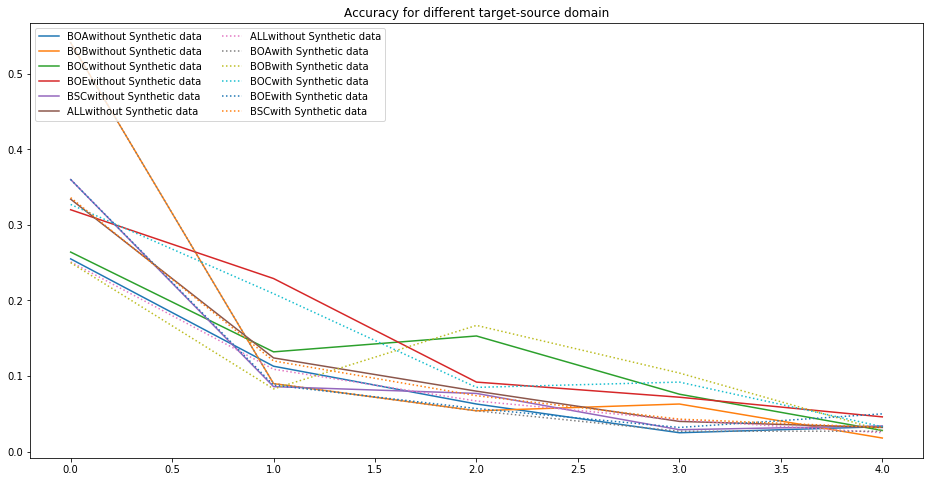

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
UG_courses +=["ALL"]
x =list(range(n))
y=[]
for i in range(n):
    print(res_dict.loc[res_dict['with Synthetic Data'] == True]['accuracy at '+str(i+1)].values)
    y+=[res_dict.loc[res_dict['with Synthetic Data'] == True]['accuracy at '+str(i+1)].values]
plt.plot(x,y)
    
x2 =list(range(n))
y2=[]
for i in range(n):
    y2 += [res_dict.loc[res_dict['with Synthetic Data'] == False]['accuracy at '+str(i+1)].values]
        
plt.plot(x2,y2, label = "with synthetic data",linestyle='dotted',)


plt.title('Accuracy for different target-source domain')
plt.legend( list(map(lambda x: x + "without Synthetic data", UG_courses))+
           list(map(lambda x: x + "with Synthetic data", UG_courses)),loc = 'upper left', ncol=2,)
# Display a figure.
plt.show()

In [189]:
res_dict.to_csv('classification visualisation result.csv', mode='a', )


In [12]:
res_dict

,method,with Synthetic Data,Train set size,Test set size,f1_score_weighted,accuracy_score,accuracy at 1,accuracy at 2,accuracy at 3,accuracy at 4,accuracy at 5,domain,recommendation Top 1most frequent,recommendation Top 1second most frequent,recommendation Top 2most frequent,recommendation Top 2second most frequent,target-source domain proportion
0,KNeighborsClassifier,0.0,5198.0,239.0,0.126509,0.251046,0.251,0.109,0.067,0.042,0.025,BOA,[MC-JURISD],[MC-TEACHSA],[MC-TEACHSA],[D01LF],956:4242
1,KNeighborsClassifier,1.0,5198.0,239.0,0.128377,0.255230,0.255,0.113,0.063,0.025,0.033,BOA,[MC-JURISD],[MC-TEACHSA],[MC-TEACHSA],[D01LF],956:4242
2,KNeighborsClassifier,0.0,5326.0,111.0,0.388412,0.540541,0.541,0.090,0.054,0.027,0.027,BOB,[MC-DMED],[MC-FIN],[MC-DDENSUR],[MC-DOPTOM],442:4884
3,KNeighborsClassifier,1.0,5326.0,111.0,0.379327,0.540541,0.541,0.090,0.054,0.063,0.018,BOB,[MC-DMED],[],[MC-DDENSUR],[MC-DOPTOM],442:4884
4,KNeighborsClassifier,0.0,5293.0,144.0,0.154559,0.243056,0.250,0.083,0.167,0.104,0.028,BOC,[MC-FIN],[MC-DMED],[MC-ENG],[MC-JURISD],576:4717
5,KNeighborsClassifier,1.0,5293.0,144.0,0.133485,0.263889,0.264,0.132,0.153,0.076,0.028,BOC,[MC-FIN],[MC-DMED],[MC-ENG],[MC-JURISD],576:4717
6,KNeighborsClassifier,0.0,5284.0,153.0,0.214744,0.333333,0.327,0.209,0.085,0.092,0.033,BOE,[MC-ARCH],[MC-ARCH2Y],[MC-ENG],[MC-ARCH],610:4674
7,KNeighborsClassifier,1.0,5284.0,153.0,0.191687,0.320261,0.320,0.229,0.092,0.072,0.046,BOE,[MC-ARCH],[MC-ARCH2Y],[MC-ENG],[MC-ARCH],610:4674
8,KNeighborsClassifier,0.0,4995.0,442.0,0.190656,0.359729,0.360,0.088,0.057,0.032,0.050,BSC,[MC-ENG],[MC-ARCH2Y],[MC-DMED],[MC-DVETMED],1764:3231
9,KNeighborsClassifier,1.0,4995.0,442.0,0.190339,0.359729,0.360,0.086,0.077,0.029,0.034,BSC,[MC-ENG],[],[MC-DVETMED],[MC-DMED],1764:3231
